<a name="ilp"></a>
# Import necessary libraries and packages 

In [1]:
import pandas as pd
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam

<a name="di"></a>
# Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


In [2]:
medium_data = pd.read_csv('medium_data.csv')
medium_data.head()
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])
medium_data['title'][0]

Number of records:  6508
Number of fields:  10


'A Beginner’s Guide to Word Embedding with Gensim Word2Vec\xa0Model'

Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word. 

<a name="preprocess"></a>
# Display titles of various articles  and preprocess them

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [3]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [4]:
tokenizer = Tokenizer(oov_token='<oov>')  # For words not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


# Creating Input Sequences

In [5]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))
input_sequences[:10]

Total input sequences:  48461


[[5, 676],
 [5, 676, 68],
 [5, 676, 68, 2],
 [5, 676, 68, 2, 452],
 [5, 676, 68, 2, 452, 1518],
 [5, 676, 68, 2, 452, 1518, 14],
 [5, 676, 68, 2, 452, 1518, 14, 2455],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99],
 [1858, 23]]

<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [6]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]
input_sequences[1:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    5,  676,   68],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    5,  676,   68,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    5,  676,   68,    2,  452],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

<a name="xy"></a>
# Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [7]:
xs, labels = input_sequences[:,:-1], input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print(xs[5])
print(labels[5])
print(ys[5][14])
print(ys[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0
[0. 0. 0. ... 0. 0. 0.]


<a name="train"></a>
# Bi- LSTM Neural Network Model training

In [8]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [21]:
history =  model.fit(xs, ys, epochs=50)

Epoch 1/50
1515/1515 [==============================] - 243s 157ms/step - loss: 6.9857 - accuracy: 0.0859
Epoch 2/50
1515/1515 [==============================] - 217s 144ms/step - loss: 6.1542 - accuracy: 0.1410
Epoch 3/50
1515/1515 [==============================] - 153s 101ms/step - loss: 5.6346 - accuracy: 0.1683
Epoch 4/50
1515/1515 [==============================] - 152s 100ms/step - loss: 5.1713 - accuracy: 0.1912
Epoch 5/50
1515/1515 [==============================] - 164s 108ms/step - loss: 4.7284 - accuracy: 0.2138
Epoch 6/50
1515/1515 [==============================] - 176s 116ms/step - loss: 4.3102 - accuracy: 0.2452
Epoch 7/50
1515/1515 [==============================] - 161s 106ms/step - loss: 3.9111 - accuracy: 0.2854
Epoch 8/50
1515/1515 [==============================] - 161s 106ms/step - loss: 3.5362 - accuracy: 0.3336
Epoch 9/50
1515/1515 [==============================] - 147s 97ms/step - loss: 3.1868 - accuracy: 0.3875
Epoch 10/50
1515/1515 [========================

In [31]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

<a name="acc"></a>
# Plotting model accuracy and loss

In [18]:
model = tf.keras.models.load_model('nextwordpredictor.h5')

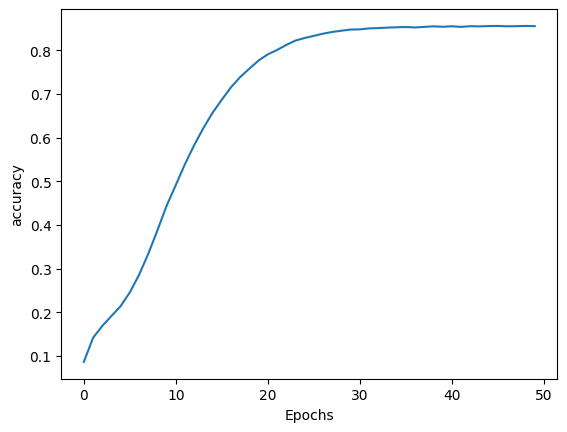

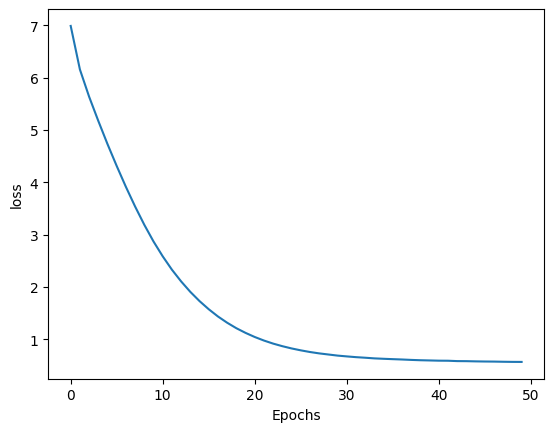

In [29]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


<a name="new"></a>
# Predicting next word of title

In [30]:
seed_text = "Akshat is"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]
    predicted_index = np.argmax(predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

Akshat is the ux
